In [99]:
%matplotlib widget
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from models import Net_4_layers_v1 as CurrentModel

Import data.

In [100]:
data_a = np.load("../data/dataset_all_H1_bootstrap_O3a.npy")
data_b = np.load("../data/dataset_all_H1_bootstrap_O3b.npy")
data_total = np.vstack([data_a, data_b])

Refering data.

In [101]:
pd.DataFrame(data_total)

,0,1,2,3,4,5,6
0,9.254420,7.831950,385.520985,43.551575,0.170024,-0.226553,3.0
1,4.918122,1.049978,244.809516,79.182049,0.563761,0.184612,0.0
2,5.831387,1.394088,105.503126,11.895160,-0.499879,0.283521,0.0
3,5.171994,1.100152,72.932770,11.926752,0.750677,-0.290788,3.0
4,5.270617,1.455858,73.913381,16.359395,0.543106,-0.148996,0.0
...,...,...,...,...,...,...,...
75595,23.099025,39.565564,91.711134,9.598615,-0.543590,0.430138,4.0
75596,18.977332,26.400047,167.938280,36.568601,-0.208704,0.199369,2.0
75597,45.583568,58.212200,64.404370,34.368289,-0.255531,-0.479915,1.0
75598,4.319583,0.991927,92.770109,17.860022,-0.136445,0.002160,0.0


Divide data into training set, validating set and testing set.

In [102]:
data_length = len(data_total)

training_set_length = int(data_length * 0.7)
validating_set_length = int(data_length * 0.2)
testing_set_length = data_length - training_set_length #- validating_set_length

training_set = data_total[0:training_set_length, :]
validating_set = data_total[training_set_length:training_set_length + validating_set_length, :]
testing_set = data_total[training_set_length:, :]

Determine the device.

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Make the data suitable to pytorch.

In [104]:
input_tensor_training = torch.tensor(training_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_training = torch.tensor(training_set[:, 6], dtype=torch.int64).to(device)

input_tensor_validating = torch.tensor(validating_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_validating = torch.tensor(validating_set[:, 6], dtype=torch.int64).to(device)

input_tensor_testing = torch.tensor(testing_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_testing = torch.tensor(testing_set[:, 6], dtype=torch.int64).to(device)

dataset_training = TensorDataset(input_tensor_training, label_tensor_training)
dataset_validating = TensorDataset(input_tensor_validating, label_tensor_validating)
dataset_testing = TensorDataset(input_tensor_testing, label_tensor_testing)

loader_training = DataLoader(dataset_training, batch_size=32, shuffle=True)
loader_validating = DataLoader(dataset_validating, batch_size=32, shuffle=True)
loader_testing = DataLoader(dataset_testing, batch_size=32, shuffle=True)

Define the model, criterion and optimizer.

In [105]:
model = CurrentModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.000025)

In [106]:
import torch

# Your training loop
loss_average_list = []
accuracy_average_list = []
test_loss_average_list = []
test_accuracy_average_list = []

for epoch in tqdm(range(1000), desc="Training ..."):
    model.train()  # Set the model to training mode
    correct_predictions = 0
    total_samples = 0
    loss_array = []

    for data in loader_training:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_array.append(loss.item())

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    loss_average = sum(loss_array) / len(loss_array)
    accuracy_average = correct_predictions / total_samples
    loss_average_list.append(loss_average)
    accuracy_average_list.append(accuracy_average)

    #validation loop
    model.eval()  
    correct_predictions_test = 0
    total_samples_test = 0
    loss_array_test = []

    with torch.no_grad():  # Disable gradient computation during testing
        for data in loader_testing:
            inputs_test, labels_test = data[0].to(device), data[1].to(device)
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            loss_array_test.append(loss_test.item())

            _, predicted_test = torch.max(outputs_test, 1)
            correct_predictions_test += (predicted_test == labels_test).sum().item()
            total_samples_test += labels_test.size(0)

    loss_average_test = sum(loss_array_test) / len(loss_array_test)
    accuracy_average_test = correct_predictions_test / total_samples_test

    test_loss_average_list.append(loss_average_test)
    test_accuracy_average_list.append(accuracy_average_test)


Training ...: 100%|██████████| 1000/1000 [19:00<00:00,  1.14s/it]


Plot the loss and average.

In [107]:
#with open('outputLoss1000e0.0025.txt', 'w') as file:
 #   file.write('\n'.join(map(str, loss_average_list)))
    
#with open('outputAcc1000e0.0025.txt', 'w') as file:
#    file.write('\n'.join(map(str, accuracy_average_list)))

#with open('outputTestLoss1000e0.0025.txt', 'w') as file:
 #   file.write('\n'.join(map(str, test_loss_average_list)))
    
#with open('outputTestAcc1000e0.0025.txt', 'w') as file:
 #   file.write('\n'.join(map(str, test_accuracy_average_list)))

In [108]:
values = [loss_average_list[-1],accuracy_average_list[-1],test_loss_average_list[-1],test_accuracy_average_list[-1]]
print(values)

[0.31135402579297466, 0.874395313681028, 0.3519598329794424, 0.8645943562610229]


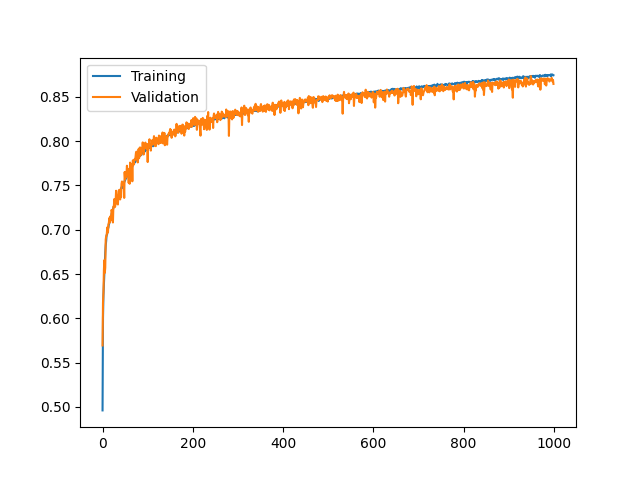

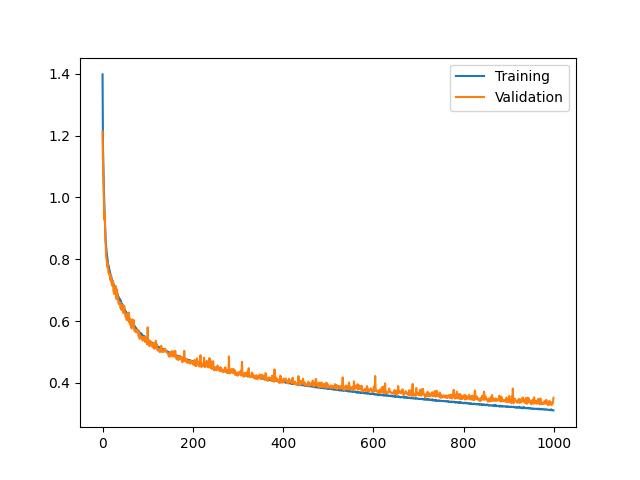

In [109]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.plot(loss_average_list, label="Training")
ax1.plot(test_loss_average_list, label="Validation")
#ax1.set_yscale("log")
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.plot(accuracy_average_list, label="Training")
ax2.plot(test_accuracy_average_list, label="Validation")
ax2.legend()

plt.show()



Judge the model.

In [110]:
model.eval()
all_predictions = []
all_labels = []

In [111]:
with torch.no_grad():
    for inputs, labels in loader_training:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Calculate accuracy.

In [112]:
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8729213907785336


In [113]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68      7512
           1       0.90      0.93      0.92      7563
           2       0.99      0.95      0.97      7557
           3       0.68      0.86      0.76      7610
           4       0.93      0.99      0.96      7572
           5       0.89      0.81      0.85      7552
           6       0.94      1.00      0.97      7554

    accuracy                           0.87     52920
   macro avg       0.88      0.87      0.87     52920
weighted avg       0.88      0.87      0.87     52920



In [114]:
print(confusion_matrix(all_labels, all_predictions))

[[4347  139   52 2212  302  151  309]
 [  74 7032   16  104   26  305    6]
 [  40  111 7150   32  164   47   13]
 [ 660   63    9 6534   16  216  112]
 [  28    0   17    0 7485    0   42]
 [ 169  445    2  783   23 6093   37]
 [   0    0    0    0    0    0 7554]]


Model name.

In [115]:
model_name = "test"

Save the model.

In [116]:
torch.save(model.state_dict(), "../src/" + model_name)

Load the model.

In [117]:
model = CurrentModel().to(device)
model.load_state_dict(torch.load("../src/" + model_name))

<All keys matched successfully>